In [18]:
from pathlib import Path
import numpy as np

data_path = Path("data/mariel_honey.npy")
data_raw = np.load(data_path)

def inspect_data(data):
    print("shape", data.shape)
    print("dtype", data.dtype)
    print("max", data.max())
    print("min", data.min())
    print("1q", np.percentile(data, 25))
    print("2q", np.percentile(data, 50))
    print("3q", np.percentile(data, 75))
    print("mean", data.mean())
    print("std", data.std())

inspect_data(data_raw)

shape (55, 6309, 3)
dtype float64
max 3.2632884979248047
min -6.039252281188965
1q -1.0209671258926392
2q -0.5115007758140564
3q -0.031081851571798325
mean -0.5414670479107054
std 0.9727511789020363


In [36]:
# Taken from https://github.com/mariel-pettee/choreo-graph

point_labels = ['ARIEL','C7','CLAV','LANK','LBHD','LBSH','LBWT','LELB','LFHD','LFRM','LFSH','LFWT','LHEL','LIEL','LIHAND','LIWR','LKNE','LKNI','LMT1','LMT5','LOHAND','LOWR','LSHN','LTHI','LTOE','LUPA','MBWT','MFWT','RANK','RBHD','RBSH','RBWT','RELB','RFHD','RFRM','RFSH','RFWT','RHEL','RIEL','RIHAND','RIWR','RKNE','RKNI','RMT1','RMT5','ROHAND','ROWR','RSHN','RTHI','RTOE','RUPA','STRN','T10']

reduced_joint_names = ['ARIEL','CLAV','RFSH','LFSH','RIEL','LIEL','RIWR','LIWR','RKNE','LKNE','RTOE','LTOE','LHEL','RHEL','RFWT','LFWT','LBWT','RBWT']

skeleton_lines = [
#     ( (start group), (end group) ),
    ('LHEL', 'LTOE',), # toe to heel
    ('RHEL', 'RTOE',),
    ('LMT1', 'LMT5',), # horizontal line across foot
    ('RMT1', 'RMT5',),   
    ('LHEL', 'LMT1',), # heel to sides of feet
    ('LHEL', 'LMT5',),
    ('RHEL', 'RMT1',),
    ('RHEL', 'RMT5',),
    ('LTOE', 'LMT1',), # toe to sides of feet
    ('LTOE', 'LMT5',),
    ('RTOE', 'RMT1',),
    ('RTOE', 'RMT5',),
    ('LKNE', 'LHEL',), # heel to knee
    ('RKNE', 'RHEL',),
    ('LFWT', 'RBWT',), # connect pelvis
    ('RFWT', 'LBWT',), 
    ('LFWT', 'RFWT',), 
    ('LBWT', 'RBWT',),
    ('LFWT', 'LBWT',), 
    ('RFWT', 'RBWT',), 
    ('LFWT', 'LTHI',), # pelvis to thighs
    ('RFWT', 'RTHI',), 
    ('LBWT', 'LTHI',), 
    ('RBWT', 'RTHI',), 
    ('LKNE', 'LTHI',), 
    ('RKNE', 'RTHI',), 
    ('CLAV', 'LFSH',), # clavicle to shoulders
    ('CLAV', 'RFSH',), 
    ('STRN', 'LFSH',), # sternum & T10 (back sternum) to shoulders
    ('STRN', 'RFSH',), 
    ('T10', 'LFSH',), 
    ('T10', 'RFSH',), 
    ('C7', 'LBSH',), # back clavicle to back shoulders
    ('C7', 'RBSH',), 
    ('LFSH', 'LBSH',), # front shoulders to back shoulders
    ('RFSH', 'RBSH',), 
    ('LFSH', 'RBSH',),
    ('RFSH', 'LBSH',),
    ('LFSH', 'LUPA',), # shoulders to upper arms
    ('RFSH', 'RUPA',), 
    ('LBSH', 'LUPA',), 
    ('RBSH', 'RUPA',), 
    ('LIWR', 'LIHAND',), # wrist to hand
    ('RIWR', 'RIHAND',),
    ('LOWR', 'LOHAND',), 
    ('ROWR', 'ROHAND',),
    ('LIWR', 'LOWR',), # across the wrist 
    ('RIWR', 'ROWR',), 
    ('LIHAND', 'LOHAND',), # across the palm 
    ('RIHAND', 'ROHAND',), 
    ('LFHD', 'LBHD',), # draw lines around circumference of the head
    ('LBHD', 'RBHD',),
    ('RBHD', 'RFHD',),
    ('RFHD', 'LFHD',),
    ('LFHD', 'ARIEL'), # connect circumference points to top of head
    ('LBHD', 'ARIEL'),
    ('RBHD', 'ARIEL'),
    ('RFHD', 'ARIEL'),
]

In [43]:
point_idxs = {label: i for i, label in enumerate(point_labels)}
edges = [(point_idxs[start], point_idxs[end]) for start, end in skeleton_lines]
edges = np.array(edges)
edges.shape

(58, 2)

First dimension is the edge group.
Second is the frames for a given clip.
Third is the XYZ coordinates in 3D space. 

We know the edge groups from [Pettee's previous project](https://github.com/mariel-pettee/choreography/blob/master/functions/functions.py), and we also know that groups 27 and 54 are bad edge groups. 

We reshape and mask those out. Additionally, we preprocess the data to be in the range -1 to 1.

In [ ]:
def preprocess_data(data):
    bad_groups = [26, 53]
    group_mask = np.ones(data.shape[0], dtype=bool)
    group_mask[bad_groups] = False
    data = data[group_mask]

    data = data.swapaxes(0, 1)

    min_val = data.min()
    max_val = data.max()

    data = (data - min_val) / (max_val - min_val) * 2 - 1
    return data

data = preprocess_data(data_raw)
inspect_data(data)

shape (6309, 53, 3)
dtype float64
max 1.0
min -1.0
1q 0.07633017121159724
2q 0.18945210843370397
3q 0.29176958280795195
mean 0.18195957732519916
std 0.20956774226321379


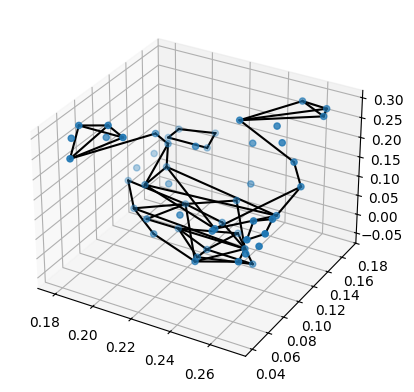

In [51]:
from matplotlib import pyplot as plt


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

frame = 200
snapshot = data[frame]
ax.scatter(snapshot[:, 0], snapshot[:, 1], snapshot[:, 2])

lines = np.array([snapshot[edges[:, 0]], snapshot[edges[:, 1]]])
lines = lines.swapaxes(0, 1)
for line in lines:
    ax.plot(line[:, 0], line[:, 1], line[:, 2], color='black')

In [37]:
point_idxs

{'ARIEL': 0,
 'C7': 1,
 'CLAV': 2,
 'LANK': 3,
 'LBHD': 4,
 'LBSH': 5,
 'LBWT': 6,
 'LELB': 7,
 'LFHD': 8,
 'LFRM': 9,
 'LFSH': 10,
 'LFWT': 11,
 'LHEL': 12,
 'LIEL': 13,
 'LIHAND': 14,
 'LIWR': 15,
 'LKNE': 16,
 'LKNI': 17,
 'LMT1': 18,
 'LMT5': 19,
 'LOHAND': 20,
 'LOWR': 21,
 'LSHN': 22,
 'LTHI': 23,
 'LTOE': 24,
 'LUPA': 25,
 'MBWT': 26,
 'MFWT': 27,
 'RANK': 28,
 'RBHD': 29,
 'RBSH': 30,
 'RBWT': 31,
 'RELB': 32,
 'RFHD': 33,
 'RFRM': 34,
 'RFSH': 35,
 'RFWT': 36,
 'RHEL': 37,
 'RIEL': 38,
 'RIHAND': 39,
 'RIWR': 40,
 'RKNE': 41,
 'RKNI': 42,
 'RMT1': 43,
 'RMT5': 44,
 'ROHAND': 45,
 'ROWR': 46,
 'RSHN': 47,
 'RTHI': 48,
 'RTOE': 49,
 'RUPA': 50,
 'STRN': 51,
 'T10': 52}

In [38]:
for a,b in skeleton_lines:
    print(a,b)

LHEL LTOE
RHEL RTOE
LMT1 LMT5
RMT1 RMT5
LHEL LMT1
LHEL LMT5
RHEL RMT1
RHEL RMT5
LTOE LMT1
LTOE LMT5
RTOE RMT1
RTOE RMT5
LKNE LHEL
RKNE RHEL
LFWT RBWT
RFWT LBWT
LFWT RFWT
LBWT RBWT
LFWT LBWT
RFWT RBWT
LFWT LTHI
RFWT RTHI
LBWT LTHI
RBWT RTHI
LKNE LTHI
RKNE RTHI
CLAV LFSH
CLAV RFSH
STRN LFSH
STRN RFSH
T10 LFSH
T10 RFSH
C7 LBSH
C7 RBSH
LFSH LBSH
RFSH RBSH
LFSH RBSH
RFSH LBSH
LFSH LUPA
RFSH RUPA
LBSH LUPA
RBSH RUPA
LIWR LIHAND
RIWR RIHAND
LOWR LOHAND
ROWR ROHAND
LIWR LOWR
RIWR ROWR
LIHAND LOHAND
RIHAND ROHAND
LFHD LBHD
LBHD RBHD
RBHD RFHD
RFHD LFHD
LFHD ARIEL
LBHD ARIEL
RBHD ARIEL
RFHD ARIEL


[(12, 24),
 (37, 49),
 (18, 19),
 (43, 44),
 (12, 18),
 (12, 19),
 (37, 43),
 (37, 44),
 (24, 18),
 (24, 19),
 (49, 43),
 (49, 44),
 (16, 12),
 (41, 37),
 (11, 31),
 (36, 6),
 (11, 36),
 (6, 31),
 (11, 6),
 (36, 31),
 (11, 23),
 (36, 48),
 (6, 23),
 (31, 48),
 (16, 23),
 (41, 48),
 (2, 10),
 (2, 35),
 (51, 10),
 (51, 35),
 (52, 10),
 (52, 35),
 (1, 5),
 (1, 30),
 (10, 5),
 (35, 30),
 (10, 30),
 (35, 5),
 (10, 25),
 (35, 50),
 (5, 25),
 (30, 50),
 (15, 14),
 (40, 39),
 (21, 20),
 (46, 45),
 (15, 21),
 (40, 46),
 (14, 20),
 (39, 45),
 (8, 4),
 (4, 29),
 (29, 33),
 (33, 8),
 (8, 0),
 (4, 0),
 (29, 0),
 (33, 0)]